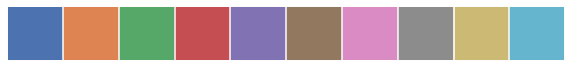

In [141]:
import pandas as pd
import numpy as np
import seaborn as sns; sns.set('talk')
import matplotlib.pyplot as plt
params = {'legend.fontsize': 'large',
          'figure.figsize': (16, 9),
         'axes.labelsize': 'medium',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'small',
         'ytick.labelsize':'small'}
plt.rcParams.update(params)
import json
from pandas.io.json import json_normalize
current_palette = sns.color_palette()
sns.palplot(current_palette)

In [77]:
results = {
    'b-resnet' : pd.read_json('../edge_test/nuc_2_jetson_b-resnet.json'),
    'b-densenet' : pd.read_json('../edge_test/nuc_2_jetson_b-densenet.json')
}

top-5 accuracy

In [87]:
top5  = { x : np.array(results[x].loc[(results[x]['index_top5'] != -1)].groupby('exit').count()['index_top5'].tolist()) / 5000 for x in results }
top5

{'b-resnet': array([0.738 , 0.8792, 0.9648, 0.9696]),
 'b-densenet': array([0.7862, 0.917 , 0.9452, 0.965 ])}

In [138]:
top1 = {x : np.array(results[x].loc[(results[x]['correct'] == True)].groupby('exit').count()['correct'].tolist()) / 5000 for x in results }
top1

{'b-resnet': array([0.4394, 0.6684, 0.8698, 0.8826]),
 'b-densenet': array([0.5114, 0.7452, 0.8292, 0.866 ])}

In [131]:
combined_top5 = {}
for net in results:
    all_wrong = 0
    for _, d in results[net].groupby('sample'):
        if all(i == -1 for i in d.index_top5.tolist()):
            all_wrong +=1 
    combined_top5[net] = (5000 - all_wrong) / 5000
combined_top5

{'b-resnet': 0.9824, 'b-densenet': 0.978}

In [133]:
combined_top1 = {}
for net in results:
    one_is_right = 0
    for _, d in results[net].groupby('sample'):
        if any(i==0 for i in d.index_top5.tolist()):
            one_is_right += 1
    combined_top1[net] = one_is_right / 5000
combined_top1

{'b-resnet': 0.9152, 'b-densenet': 0.9132}

[Text(0, 0.5, 'Accuracy'), Text(0.5, 0, 'Exit-#')]

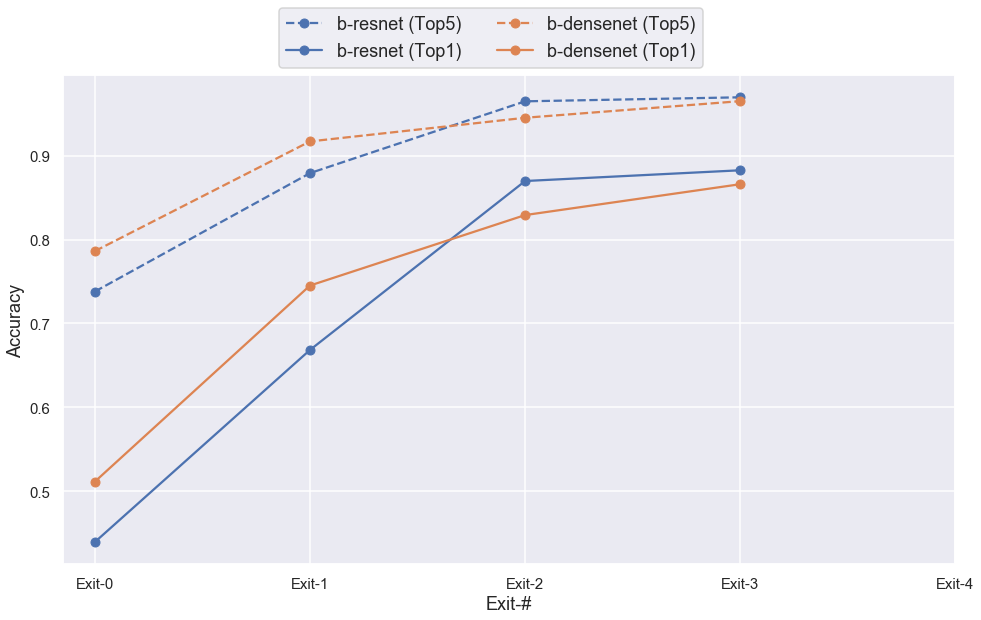

In [192]:
fig, ax = plt.subplots(1,1)
x = np.arange(5)
for i, net in enumerate(results):
    ax.plot(top5[net], '--o', color=current_palette[i])
    ax.plot(top1[net], '-o', color=current_palette[i])
    
    
ax.set_xticks(x)
ax.set_xticklabels(['Exit-{}'.format(x) for x in range(5)])
fig.legend([val for sublist in [['{} (Top5)'.format(x) ]+ ['{} (Top1)'.format(x)] for x in results] for val in sublist], 
           ncol=2, loc="upper center", fontsize='medium')

ax.set(xlabel='Exit-#', ylabel='Accuracy')

In [216]:
nets = {}
for net in results:
    best_exit = np.zeros(4)
    best_score = np.zeros(4)
    score_correct = np.zeros(4)
    worst_mistaken = np.zeros(4)
    for i, d in results[net].groupby('sample'):
        #tmp = d[np.argmax(d.scores.tolist()[0]):1]
        correct = np.array(d.correct.tolist())
        
        incorrect = ~correct
        scores = np.array(d.scores.tolist())

        combined = np.argmax(correct[:] * scores[:,0])
        combined_incorrect = np.argmax(incorrect*scores[:,0])

        #print(scores[:,0])
        exit = np.argmax(d.scores.tolist())//4
        #print(exit)
        # (d[exit:exit+1].exit.item())
        best_score[exit] +=1
        best_exit += correct
        score_correct[combined] += 1
        worst_mistaken[combined_incorrect] +=1

    nets[net] = np.array([best_exit, best_score, score_correct])
nets

{'b-resnet': array([[2197., 3342., 4349., 4413.],
        [  29.,  142., 1392., 3437.],
        [ 463.,  141., 1255., 3141.]]),
 'b-densenet': array([[2557., 3726., 4146., 4330.],
        [  41.,  383., 2103., 2473.],
        [ 492.,  335., 1881., 2292.]])}

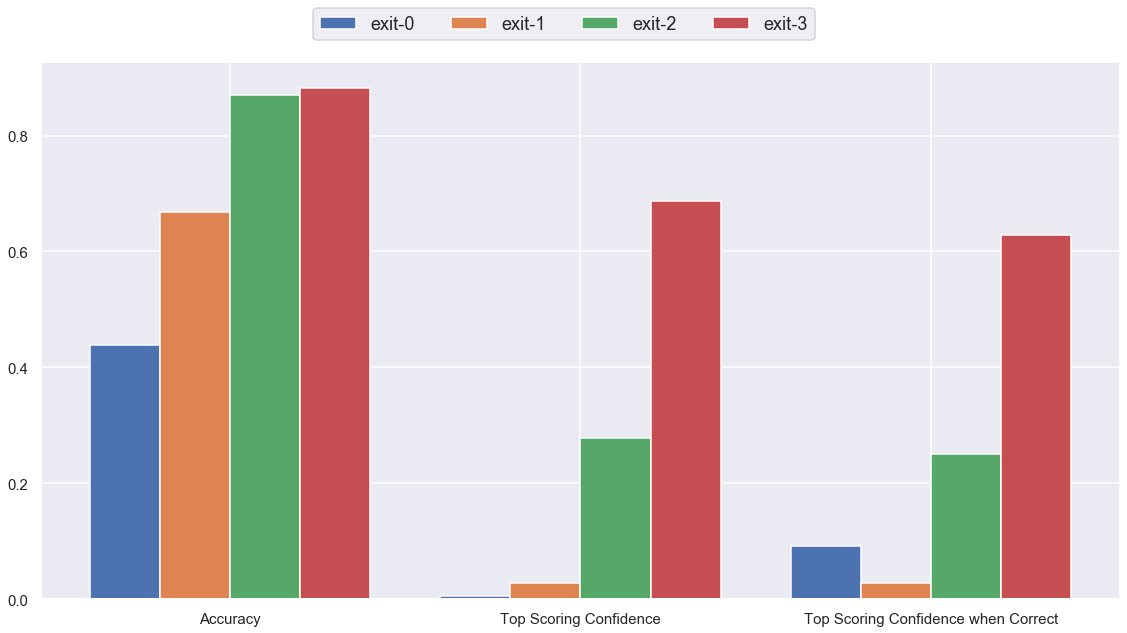

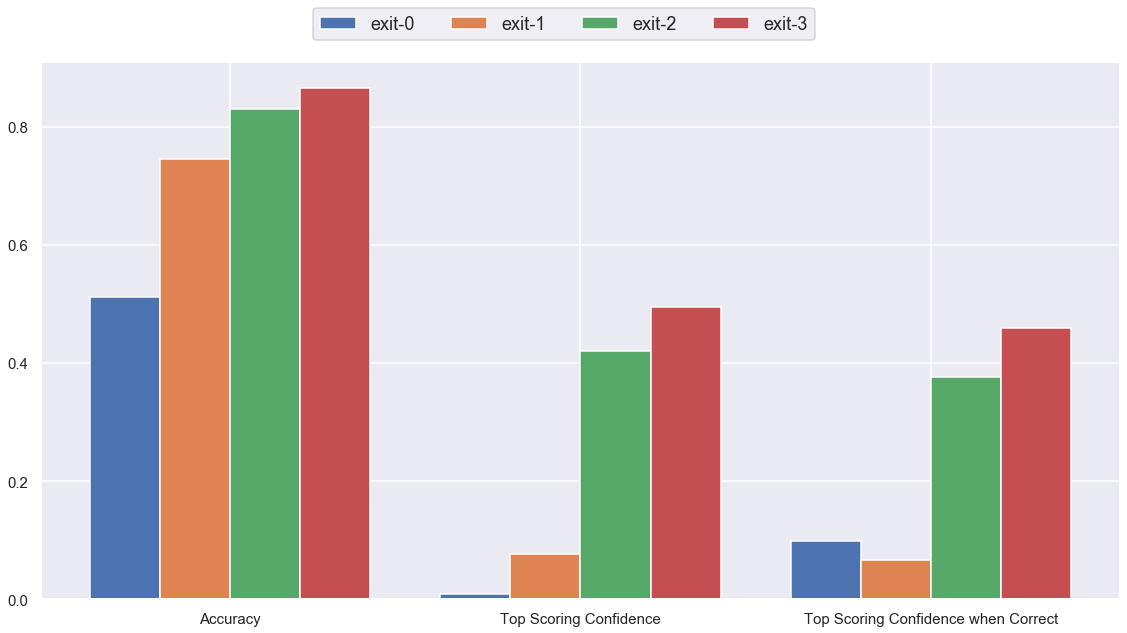

In [224]:
for net in nets:
    fig, ax = plt.subplots(1,1)
    x = np.arange(3)
    width = 0.2
    #ax.bar(x-width, best_exit, width=width)
    #ax.bar(x, best_score, width=width)
    #ax.bar(x+width, score_correct, width=width)
    for index_offset, exit_n in zip([-1.5,-.5,.5,1.5], range(4)):
        ax.bar(x+(width*index_offset), nets[net].T[exit_n] / 5000, width=width)

    ax.set_xticks(x)
    ax.set_xticklabels(['Accuracy', 'Top Scoring Confidence', 'Top Scoring Confidence when Correct'])

    fig.legend(['exit-{}'.format(x) for x in range(4)], ncol=4, loc="upper center", fontsize='medium')
    fig.tight_layout()
    fig.subplots_adjust(top=0.90)
    plt.savefig(net + '_correctness.png')